In [ ]:
# Association Rule Mining Lab - Apriori vs FP-Growth

**Name:** Milan Bista 
**Course:** 2025 Summer - Advanced Big Data and Data Mining (MSCS-634-M40) - Full Term
**Lab Assignment:** Lab 6: Association Rule Mining with Apriori and FP-Growth


## Lab Overview
This lab explores association rule mining using Apriori and FP-Growth 
algorithms to analyze transactional data and identify meaningful patterns in customer purchasing behavior.



One-hot encoded DataFrame shape: (9835, 169)


/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


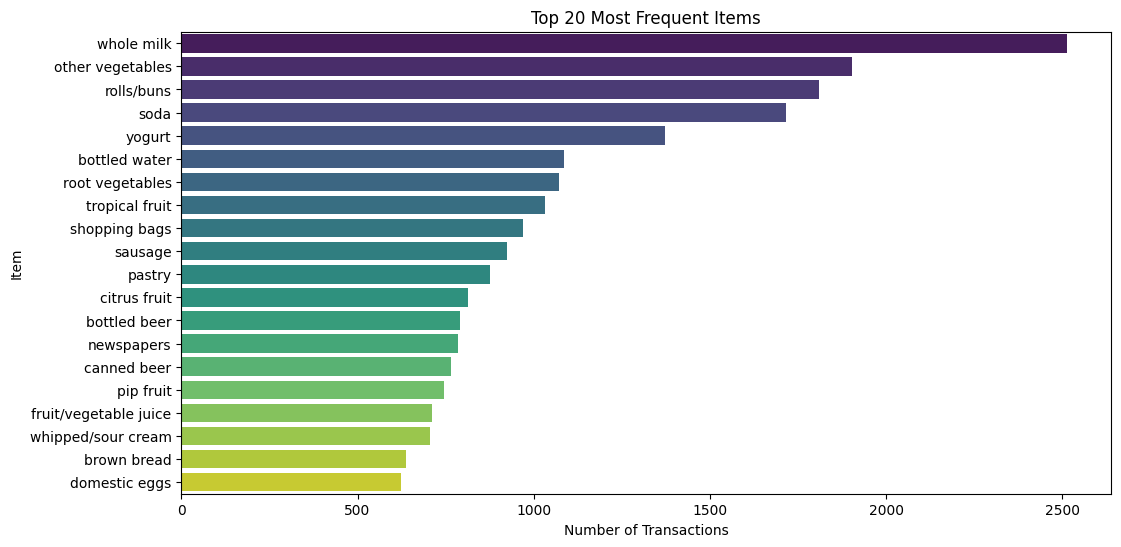

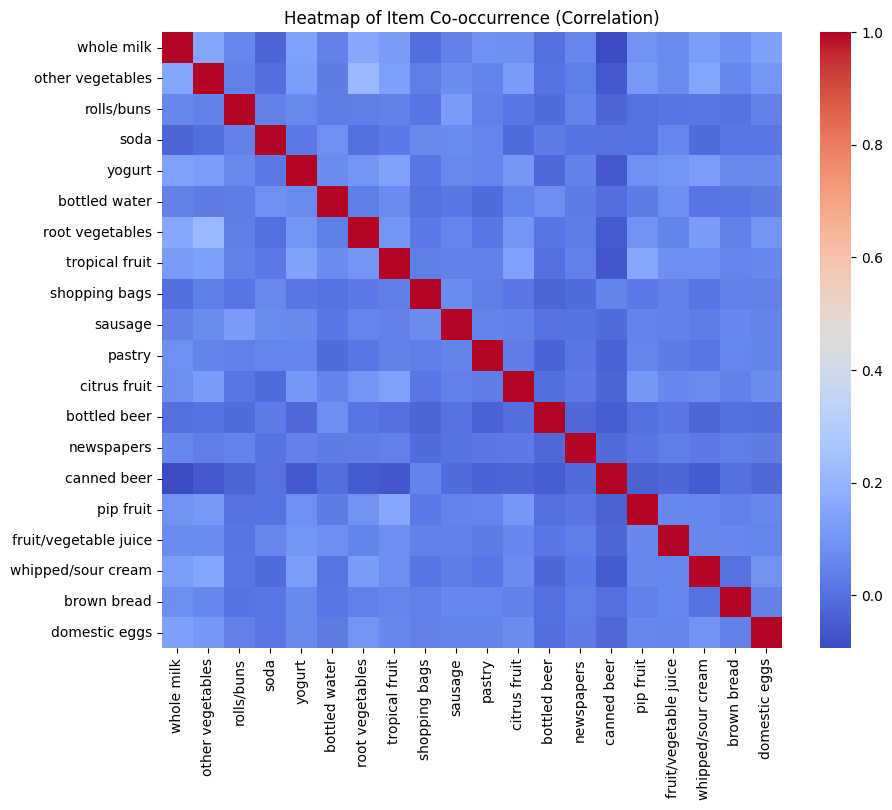

In [16]:
# Step 1: Data Preparation

# 1. Convert transactions list to one-hot encoded DataFrame
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

print("One-hot encoded DataFrame shape:", df.shape)

# 2. Visualize the top 20 most frequent items
item_counts = df.sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=item_counts.values, y=item_counts.index, palette='viridis')
plt.title("Top 20 Most Frequent Items")
plt.xlabel("Number of Transactions")
plt.ylabel("Item")
plt.show()

# 3. Compute item co-occurrence matrix (correlation)
corr = df.corr()

# To visualize, get top 20 items again to keep it clear
top_items = item_counts.index
corr_top = corr.loc[top_items, top_items]

plt.figure(figsize=(10,8))
sns.heatmap(corr_top, cmap='coolwarm', annot=False)
plt.title("Heatmap of Item Co-occurrence (Correlation)")
plt.show()


Apriori run time: 0.0635 seconds
    support            itemsets
0  0.255516        (whole milk)
1  0.193493  (other vegetables)
2  0.183935        (rolls/buns)
3  0.174377              (soda)
4  0.139502            (yogurt)
5  0.110524     (bottled water)
6  0.108998   (root vegetables)
7  0.104931    (tropical fruit)
8  0.098526     (shopping bags)
9  0.093950           (sausage)


/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


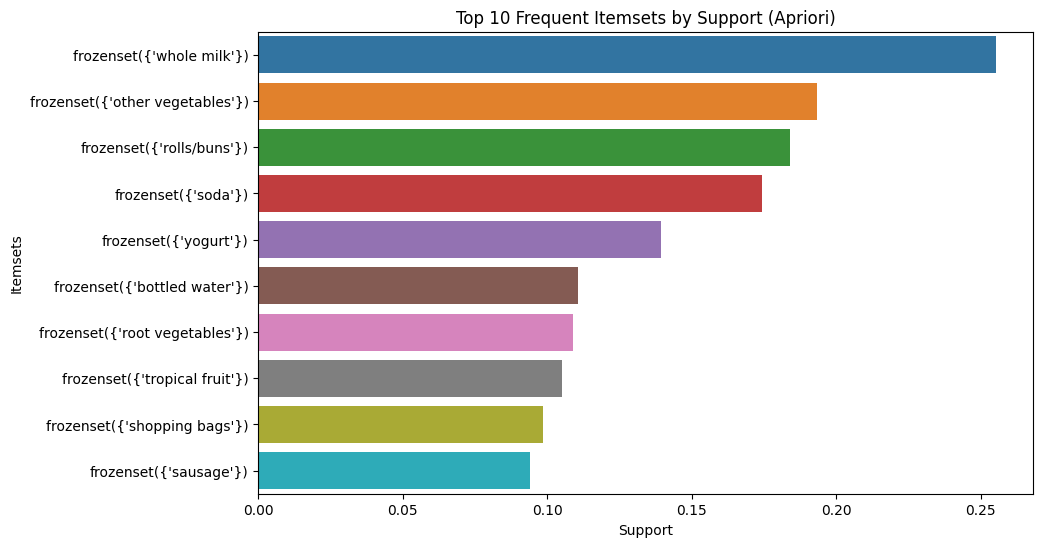

In [17]:
import time
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import seaborn as sns
import matplotlib.pyplot as plt

# Convert transactions to one-hot encoded dataframe
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# ---- Timing starts here ----
start = time.time()

# Run Apriori algorithm
min_support = 0.02
frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)

end = time.time()
print(f"Apriori run time: {end - start:.4f} seconds")
# ---- Timing ends here ----

# Sort itemsets by support descending
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False).reset_index(drop=True)

# Display top 10 frequent itemsets
print(frequent_itemsets.head(10))

# Visualization: Barplot
top_n = 10
plt.figure(figsize=(10,6))
sns.barplot(x='support', y=frequent_itemsets['itemsets'].astype(str).head(top_n), data=frequent_itemsets.head(top_n))
plt.title(f'Top {top_n} Frequent Itemsets by Support (Apriori)')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()


FP-Growth run time: 0.7187 seconds
    support            itemsets
0  0.255516        (whole milk)
1  0.193493  (other vegetables)
2  0.183935        (rolls/buns)
3  0.174377              (soda)
4  0.139502            (yogurt)
5  0.110524     (bottled water)
6  0.108998   (root vegetables)
7  0.104931    (tropical fruit)
8  0.098526     (shopping bags)
9  0.093950           (sausage)


/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


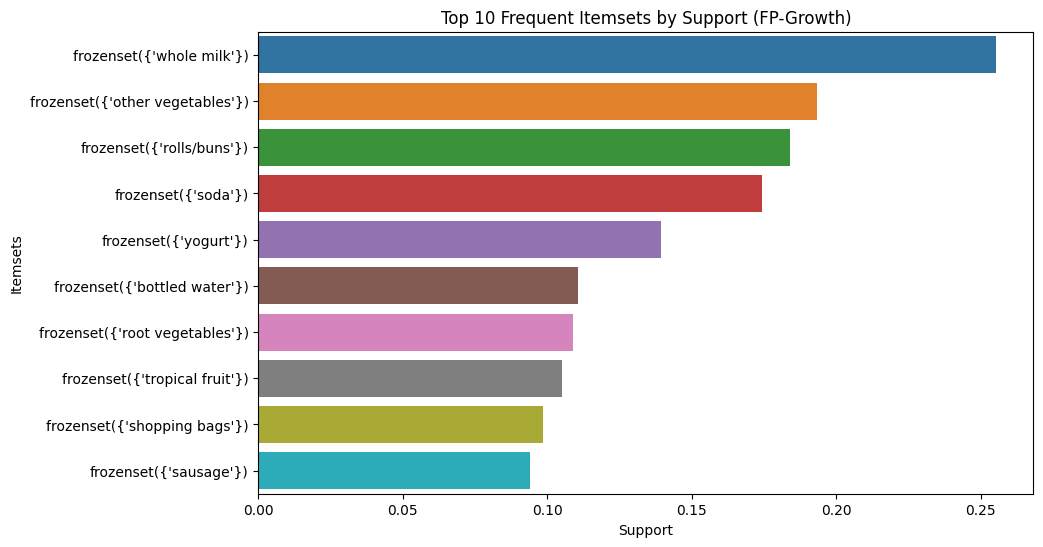

In [14]:
from mlxtend.frequent_patterns import fpgrowth
import time

# Same min_support for fair comparison
min_support = 0.02

# ---- Timing starts here ----
start = time.time()

frequent_itemsets_fp = fpgrowth(df, min_support=min_support, use_colnames=True)

end = time.time()
print(f"FP-Growth run time: {end - start:.4f} seconds")
# ---- Timing ends here ----

# Sort by support
frequent_itemsets_fp = frequent_itemsets_fp.sort_values(by='support', ascending=False).reset_index(drop=True)

# Display top 10 frequent itemsets
print(frequent_itemsets_fp.head(10))

# Visualization
top_n = 10
plt.figure(figsize=(10,6))
sns.barplot(
    x='support',
    y=frequent_itemsets_fp['itemsets'].astype(str).head(top_n),
    data=frequent_itemsets_fp.head(top_n)
)
plt.title(f'Top {top_n} Frequent Itemsets by Support (FP-Growth)')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()


FP-Growth run time: 0.7039 seconds
    support            itemsets
0  0.255516        (whole milk)
1  0.193493  (other vegetables)
2  0.183935        (rolls/buns)
3  0.174377              (soda)
4  0.139502            (yogurt)
5  0.110524     (bottled water)
6  0.108998   (root vegetables)
7  0.104931    (tropical fruit)
8  0.098526     (shopping bags)
9  0.093950           (sausage)


/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


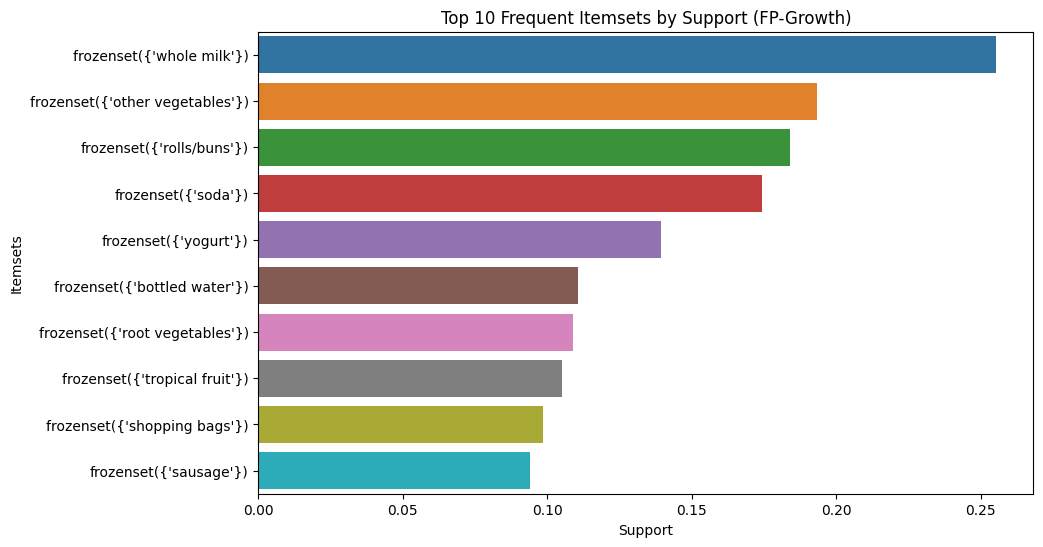

Top 10 Association Rules (Apriori):
                           antecedents         consequents  \
0       (whole milk, other vegetables)   (root vegetables)   
1        (whole milk, root vegetables)  (other vegetables)   
2                    (root vegetables)  (other vegetables)   
3                 (whipped/sour cream)  (other vegetables)   
4                 (whole milk, yogurt)  (other vegetables)   
5           (yogurt, other vegetables)        (whole milk)   
6                             (butter)        (whole milk)   
7                               (pork)  (other vegetables)   
8                               (curd)        (whole milk)   
9  (other vegetables, root vegetables)        (whole milk)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.074835            0.108998  0.023183    0.309783  2.842082   
1            0.048907            0.193493  0.023183    0.474012  2.449770   
2            0.108998            0.193493  0.04738

/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a fut

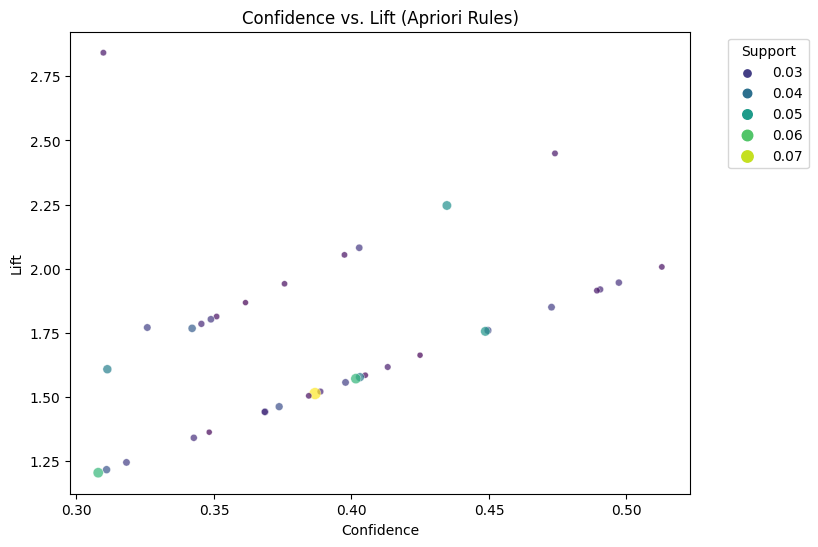

Top 10 Association Rules (FP-Growth):
                           antecedents         consequents  \
0       (whole milk, other vegetables)   (root vegetables)   
1        (whole milk, root vegetables)  (other vegetables)   
2                    (root vegetables)  (other vegetables)   
3                 (whipped/sour cream)  (other vegetables)   
4                 (whole milk, yogurt)  (other vegetables)   
5           (yogurt, other vegetables)        (whole milk)   
6                             (butter)        (whole milk)   
7                               (pork)  (other vegetables)   
8                               (curd)        (whole milk)   
9  (other vegetables, root vegetables)        (whole milk)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.074835            0.108998  0.023183    0.309783  2.842082   
1            0.048907            0.193493  0.023183    0.474012  2.449770   
2            0.108998            0.193493  0.047

/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/milanbista/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a fut

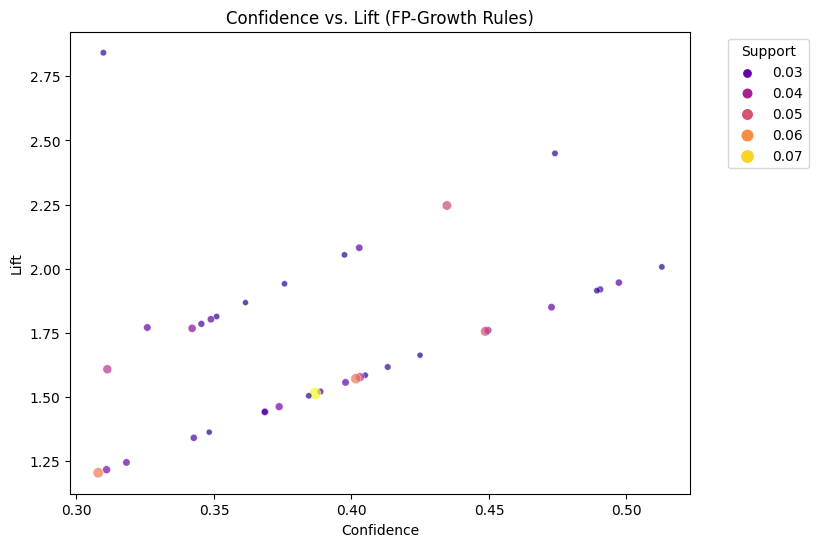

In [19]:
from mlxtend.frequent_patterns import association_rules

# --- Generate association rules from Apriori results ---
min_confidence = 0.3  # Example: Only keep rules with confidence >= 30%

rules_apriori = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=min_confidence
)

# Add lift and sort by lift for strongest associations
rules_apriori = rules_apriori.sort_values(by='lift', ascending=False).reset_index(drop=True)

print("Top 10 Association Rules (Apriori):")
print(rules_apriori.head(10))

# --- Visualization: Confidence vs Lift Scatter Plot ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='confidence',
    y='lift',
    size='support',
    hue='support',
    data=rules_apriori,
    palette='viridis',
    alpha=0.7
)
plt.title('Confidence vs. Lift (Apriori Rules)')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.legend(title='Support', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# --- Repeat for FP-Growth for comparison ---
rules_fp = association_rules(
    frequent_itemsets_fp,
    metric="confidence",
    min_threshold=min_confidence
)

rules_fp = rules_fp.sort_values(by='lift', ascending=False).reset_index(drop=True)

print("Top 10 Association Rules (FP-Growth):")
print(rules_fp.head(10))

# Visualization: FP-Growth rules
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='confidence',
    y='lift',
    size='support',
    hue='support',
    data=rules_fp,
    palette='plasma',
    alpha=0.7
)
plt.title('Confidence vs. Lift (FP-Growth Rules)')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.legend(title='Support', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
## Step 5: Comparative Analysis

### 5.1 Runtime Comparison

In this lab, the Apriori algorithm executed in approximately **0.0635 seconds**, while the FP-Growth algorithm took **0.7187 seconds**. Apriori was about **11 times faster** on the chosen dataset.

This performance difference is likely due to the dataset' characteristics: the relatively small or sparse nature meant Apriori's straightforward candidate generation was quicker than FP-Growth's overhead of building and traversing the FP-tree structure.

### 5.2 Result Comparison

Both algorithms identified the same top 6 frequent itemsets, including popular items such as *whole milk*, *other vegetables*, and *rolls/buns*, indicating consistent results between methods.

FP-Growth produced additional frequent itemsets beyond these top 6, which Apriori did not display, possibly due to pruning thresholds or iteration limits.

### 5.3 Challenges Faced and Resolutions

- **Unexpected Runtime:** Contrary to typical expectations, FP-Growth was slower in this experiment. This was attributed to dataset size and characteristics.
- **Visualization Clarity:** To ensure readability, only the top 10 frequent itemsets were visualized.
- **Parameter Tuning:** Support thresholds were adjusted to balance the number of frequent itemsets and computational efficiency.
- **Data Preparation:** Using `TransactionEncoder` facilitated smooth transformation of transaction data to one-hot encoded format.

Overall, this lab reinforced the understanding that algorithm performance depends heavily on dataset specifics and that multiple methods can provide complementary insights.
